<a href="https://colab.research.google.com/github/Vasanta2002/sprint_7/blob/main/JDS_SHR_231_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Define ML Problems
- Data Leakage
- ROC/AUC Curve



In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 500)

# Define ML problems

# I. Wrangle Data

In [4]:
def wrangle(filepath):

  df = pd.read_csv(filepath)

  # Import w/ DateTimeIndex
  df = pd.read_csv(filepath, parse_dates=['Date'], index_col = 'Date')
  
  # drop rows with no overall rating
  df.dropna(subset=['overall'], inplace = True)

  # Create `'great'` column as target
  df['great'] = (df['overall'] >= 4).astype(int)  

  # Drop overall column to prevent data leakage
  df.drop(columns='overall', inplace = True)

  # Clean binary encoded columns
  categorical_cols = df.select_dtypes('object').columns
  # use categorical columns which are basically binary encoded
  binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]
  for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)

  # Drop high-cardinality categorical variables
  threshold = 20

  high_card_cols =  [col for col in categorical_cols
                     if df[col].nunique() > threshold ]
  df.drop(high_card_cols, axis=1, inplace=True)

  # Dropping columns with high number of NaN values
  df.dropna(axis=1, thresh=300, inplace = True)

  return df

In [5]:
df =wrangle(DATA_PATH + 'burritos/burritos.csv')

In [6]:
df.columns

Index(['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Unreliable',
       'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce',
       'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini', 'great'],
      dtype='object')

In [7]:
df.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# II. Split Data

In [8]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

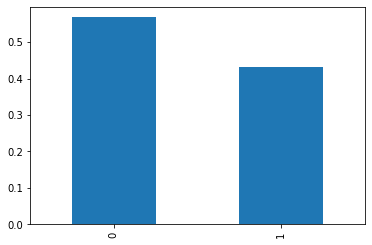

In [9]:
y.value_counts(normalize=True).plot(kind='bar')

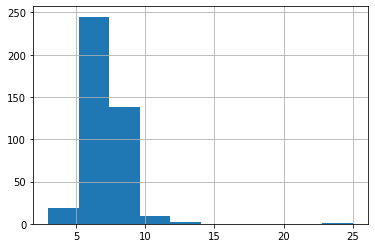

In [10]:
X['Cost'].hist()

In [11]:
y.resample('y').sum()

Date
2011-12-31      0
2012-12-31      0
2013-12-31      0
2014-12-31      0
2015-12-31      1
2016-12-31    121
2017-12-31     38
2018-12-31     13
2019-12-31      8
2020-12-31      0
2021-12-31      0
2022-12-31      0
2023-12-31      0
2024-12-31      0
2025-12-31      0
2026-12-31      1
Freq: A-DEC, Name: great, dtype: int64

In [12]:
# Training 
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation 
validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing 
test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

# III. Establish Baseline

In [13]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build Model

In [14]:
# Model 1: Logistic Regression

model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [15]:
# Model 2: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**

accuracy = (tp + tn) / (tp + fp + tn + fn)

In [16]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


In [17]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8823529411764706


**Precision, Recall, F1**

precision = tp / (tp + fp)


recall = tp / (tp + fn)

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


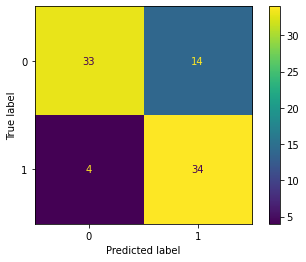

In [18]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)));
plot_confusion_matrix(model_lr, X_val,y_val);

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        47
           1       0.85      0.89      0.87        38

    accuracy                           0.88        85
   macro avg       0.88      0.88      0.88        85
weighted avg       0.88      0.88      0.88        85



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


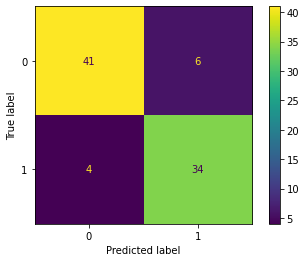

In [19]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)));
plot_confusion_matrix(model_rf, X_val,y_val);

**ROC curve**


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


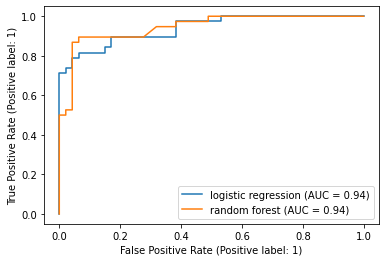

In [20]:
lr = plot_roc_curve(
    model_lr,
    X_val,
    y_val,
    name = 'logistic regression'
)

rf = plot_roc_curve(
    model_rf,
    X_val,
    y_val,
    ax = lr.ax_,
    name = 'random forest'
)

In [21]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.944568868980963

In [23]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.9384098544232923

In [24]:
# Get predicted probabilities from model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds':thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,2.00
1,0.000000,0.026316,1.00
2,0.000000,0.052632,0.98
3,0.000000,0.105263,0.97
4,0.000000,0.210526,0.96
5,0.000000,0.263158,0.93
6,0.000000,0.368421,0.91
7,0.000000,0.500000,0.82
8,0.021277,0.500000,0.81
9,0.021277,0.526316,0.80


## Demonstrating how changing the threshold (from roc-auc curve) changes the metrics

In [28]:
y_pred_prob[y_pred_prob>= 0.60] = 1
y_pred_prob[y_pred_prob < 0.60] = 0

In [29]:
from sklearn.metrics import accuracy_score
print('Validation Accuracy (RF):', accuracy_score(y_val, y_pred_prob))

Validation Accuracy (RF): 0.8941176470588236


              precision    recall  f1-score   support

           0       0.91      0.87      0.89        47
           1       0.85      0.89      0.87        38

    accuracy                           0.88        85
   macro avg       0.88      0.88      0.88        85
weighted avg       0.88      0.88      0.88        85



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


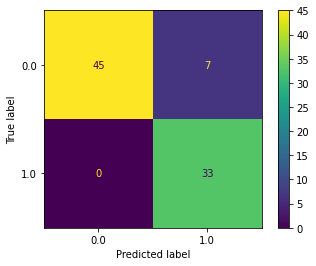

In [30]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_pred_prob); 

## Regression Example

What if we were predicting the cost of a burrito? 


In [ ]:
# target = 'Cost'
# y = df[target]
# X = df.drop(columns=target)

In [ ]:
# df['Cost'].hist(bins=20) # to check for target skewness

In [ ]:
# Radomized Train Test Split 
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# from sklearn.metrics import mean_absolute_error
# baseline_pred = [y_val.mean()] * len(y_val)
# mean_absolute_error(y_val, baseline_pred)

In [ ]:

# model_lr = make_pipeline(SimpleImputer(), 
#                       StandardScaler(), 
#                       LinearRegression())

# model_lr.fit(X_train, y_train)

In [ ]:

# model_rf = make_pipeline(SimpleImputer(),  
#                       RandomForestRegressor())

# model_rf.fit(X_train, y_train)

In [ ]:
# print("Training Accuracy - Linear Regression", mean_absolute_error(y_train, model_lr.predict(X_train)))
# print("Validation Accuracy - Linear Regression", mean_absolute_error(y_val, model_lr.predict(X_val)))

In [ ]:
# print("Training Accuracy - Random Forest", mean_absolute_error(y_train, model_rf.predict(X_train)))
# print("Validation Accuracy - Random Forest", mean_absolute_error(y_val, model_rf.predict(X_val)))

# Log Transformation of skewed Target (for regression)

In [ ]:
# The chosen target for the above example (burrito cost) is not skewed. But if your regression target is skewed, then you should log transform it, using the following steps:

# log transform your target (training set)
# y_train_log = np.log1p(y_train)

# fit your chosen model to this log tranformed target
# model.fit(X_train, y_train_log)

# get your predictions for this log tranformed target
# y_pred_log = model.predict(X_val)

# reverse log tranform your log tranformed target
# y_pred = np.expm1(y_pred_log)

# check your metrics
# print(mean_absolute_error(y_val, y_pred))


# Sampling of imbalance data (using .sample function)

This is just one way to over or under sample. Go over these links and read how to implement SMOTE(Synthetic Minority Oversampling Technique) technique too, where you create synthetic observations of the minority class! 

* https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html
* https://www.section.io/engineering-education/imbalanced-data-in-ml/

In [ ]:
# # Sampling of imbalance data (using .sample function)

# # If train_minority contains only those rows in your training dataset that correspond to minority class, you can oversample like this.
# # When you over sample your minority class, you always have to sample with replacement

# num_minority_samples = 10 # number of additional minority class rows to create. 
# train_minority_sample = train_minority.sample(num_minority_samples,replace = True)


# # If train_majority contains only those rows in your dataset that correspond to majority class, you can undersample like this.
# # Under sampling doesnt need with replacement
# num_majority_samples = 10 # number of majority class rows to remove.
# train_majority_sample = train_majority.sample(num_majority_samples,replace=False)

# # You can then append the two dataframes to form a final train df. 
# train_final = train_minority_sample.append(train_majority_sample, ignore_index=True)